세션시간 = 30초 , 최대세션길이 = 100 , 히든레이어 = 128 , 에포크 = 7 , 트레이닝셋 분리기준일 = 280일

Recall@20: 0.203125

MRR@20: 0.064445

1. 세션id는 동일유저 아이디에서 각평점간 30초 이상 소요 시 부여했습니다.

2. 한 세셔id당 100개 이상의 평가를 한 평우 제외하였으며, 평점3점 이하 역시 제거했습니다.

3. 테스트,벨리데이션 세트는 각각 1년 단위로 분리했습니다.

In [ ]:
import datetime as dt
from pathlib import Path
import os
import time
import datetime

import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [ ]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose2/') 
train_path = data_path / 'ratings.dat'

In [ ]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data

,UserId,ItemId,Rating,Time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [ ]:
data['UserId'].nunique(), data['ItemId'].nunique(), data['Time'].nunique()

(6040, 3706, 458455)

In [ ]:
data['DateTime'] = data['Time'].apply(lambda x : datetime.datetime.fromtimestamp(x))
data

,UserId,ItemId,Rating,Time,DateTime
0,1,1193,5,978300760,2000-12-31 22:12:40
1,1,661,3,978302109,2000-12-31 22:35:09
2,1,914,3,978301968,2000-12-31 22:32:48
3,1,3408,4,978300275,2000-12-31 22:04:35
4,1,2355,5,978824291,2001-01-06 23:38:11
...,...,...,...,...,...
1000204,6040,1091,1,956716541,2000-04-26 02:35:41
1000205,6040,1094,5,956704887,2000-04-25 23:21:27
1000206,6040,562,5,956704746,2000-04-25 23:19:06
1000207,6040,1096,4,956715648,2000-04-26 02:20:48


In [ ]:
data.sort_values(['UserId', 'DateTime'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time,DateTime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


In [ ]:
cond1 = data['DateTime'] - data['DateTime'].shift(1) > datetime.timedelta(seconds = 30)
cond2 = data['UserId'] != data['UserId'].shift(1)
data['SessionId'] = (cond1|cond2).cumsum()
data

,UserId,ItemId,Rating,Time,DateTime,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,1
22,1,1270,5,978300055,2000-12-31 22:00:55,2
27,1,1721,4,978300055,2000-12-31 22:00:55,2
37,1,1022,5,978300055,2000-12-31 22:00:55,2
24,1,2340,3,978300103,2000-12-31 22:01:43,3
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,250848
999988,6040,1921,4,997454464,2001-08-10 14:41:04,250849
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,250849
1000167,6040,161,3,997454486,2001-08-10 14:41:26,250849


In [ ]:
data = data.drop('Time' , axis =1)

데이터 전처리

In [ ]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1         1
2         3
3         1
4         1
5         1
         ..
250846    2
250847    1
250848    1
250849    3
250850    1
Length: 250850, dtype: int64

In [ ]:
session_length.median(), session_length.mean()

(2.0, 3.9872792505481365)

In [ ]:
session_length.min(), session_length.max()

(1, 333)

In [ ]:
session_length.quantile(0.999)

59.0

In [ ]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1     0.319701
2     0.504198
3     0.636010
4     0.730616
5     0.801702
6     0.851648
7     0.886016
8     0.910146
9     0.927295
10    0.940147
11    0.949021
12    0.956336
13    0.962500
14    0.967223
15    0.971190
16    0.974543
17    0.977273
18    0.979805
19    0.982065
20    0.983971
21    0.985386
22    0.986845
23    0.988160
24    0.989316
25    0.990193
26    0.990971
27    0.991740
28    0.992330
29    0.992908
30    0.993430
31    0.993929
32    0.994367
33    0.994814
34    0.995105
35    0.995467
36    0.995782
37    0.996081
38    0.996380
39    0.996655
40    0.996891
41    0.997090
42    0.997265
43    0.997425
44    0.997632
45    0.997756
46    0.997915
47    0.998035
48    0.998126
49    0.998238
50    0.998322
51    0.998425
52    0.998517
53    0.998613
54    0.998676
55    0.998752
56    0.998800
57    0.998852
58    0.998920
dtype: float64

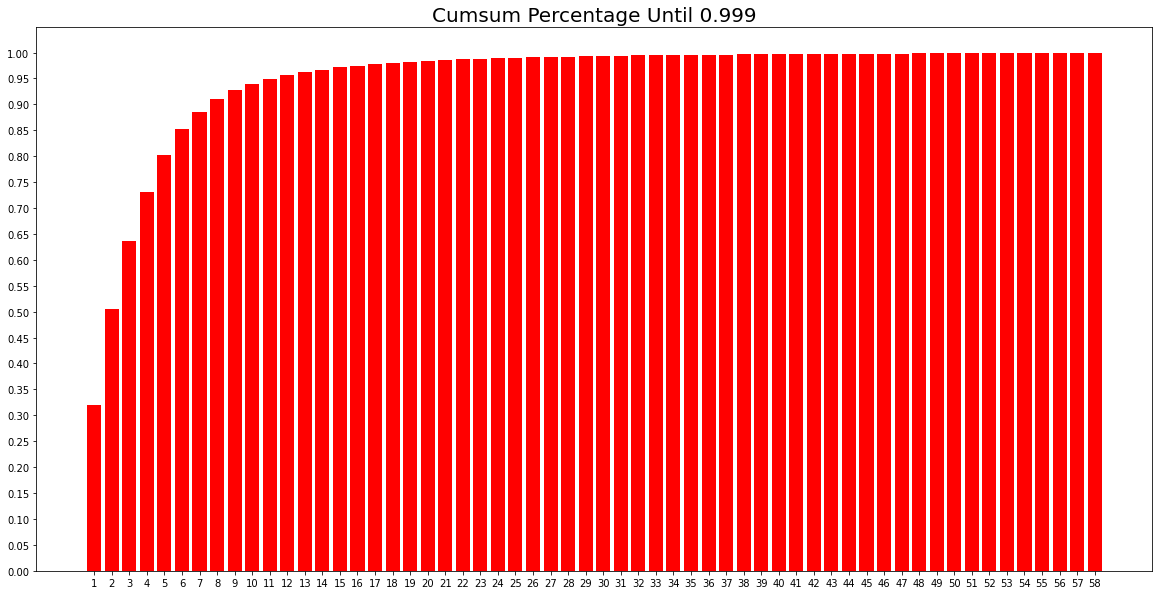

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

시간

In [ ]:
oldest, latest = data['DateTime'].min(), data['DateTime'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


데이터 클린징

In [ ]:
def cleanse_recursive(data: pd.DataFrame, longest) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, longest)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, longest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len <= longest].index
    data = data[data['SessionId'].isin(session_use)]
    return data

In [ ]:
data = cleanse_recursive(data, longest=100)
data = data[data['Rating']>=3]
data

,UserId,ItemId,Rating,DateTime,SessionId
31,1,3186,4,2000-12-31 22:00:19,1
22,1,1270,5,2000-12-31 22:00:55,2
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,2
24,1,2340,3,2000-12-31 22:01:43,3
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,250848
999988,6040,1921,4,2001-08-10 14:41:04,250849
1000172,6040,1784,3,2001-08-10 14:41:04,250849
1000167,6040,161,3,2001-08-10 14:41:26,250849


미니배치 구성

In [ ]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['DateTime'].max()
    session_last_time = data.groupby('SessionId')['DateTime'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [ ]:
tr, test = split_by_date(data, n_days=280)
tr, val = split_by_date(tr, n_days=280)

In [ ]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["DateTime"].min()}\n'
          f'\t Last Time : {data["DateTime"].max()}\n')

In [ ]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 799613
	 Sessions: 215106
	 Items: 3603
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2001-08-17 16:53:41

* valid Set Stats Info
	 Events: 21354
	 Sessions: 10381
	 Items: 2782
	 First Time : 2001-08-17 18:10:16
	 Last Time : 2002-05-24 17:41:15

* test Set Stats Info
	 Events: 12163
	 Sessions: 6602
	 Items: 2418
	 First Time : 2002-05-24 19:12:36
	 Last Time : 2003-02-28 17:49:50



In [ ]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [ ]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [ ]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [ ]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.tail(10)

,UserId,ItemId,Rating,DateTime,SessionId,item_idx
999905,6040,953,5,2001-08-10 14:36:00,250844,527
1000169,6040,2725,4,2001-08-10 14:36:20,250844,1766
1000105,6040,1673,4,2001-08-10 14:36:52,250845,404
1000118,6040,457,4,2001-08-10 14:39:09,250846,124
1000119,6040,3671,4,2001-08-10 14:39:27,250846,168
999923,6040,232,5,2001-08-10 14:39:58,250847,978
1000019,6040,2917,4,2001-08-10 14:40:29,250848,1102
999988,6040,1921,4,2001-08-10 14:41:04,250849,315
1000172,6040,1784,3,2001-08-10 14:41:04,250849,87
1000167,6040,161,3,2001-08-10 14:41:26,250849,410


In [ ]:
tr_dataset.click_offsets

array([     0,      1,      4, ..., 799609, 799610, 799613], dtype=int32)

In [ ]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 215103, 215104, 215105])

In [ ]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [ ]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,DateTime,SessionId,item_idx
31,1,3186,4,2000-12-31 22:00:19,1,0
22,1,1270,5,2000-12-31 22:00:55,2,1
27,1,1721,4,2000-12-31 22:00:55,2,2
37,1,1022,5,2000-12-31 22:00:55,2,3
24,1,2340,3,2000-12-31 22:01:43,3,4
36,1,1836,5,2000-12-31 22:02:52,4,5
3,1,3408,4,2000-12-31 22:04:35,5,6
7,1,2804,5,2000-12-31 22:11:59,6,7
47,1,1207,4,2000-12-31 22:11:59,6,8
0,1,1193,5,2000-12-31 22:12:40,7,9


In [ ]:
iter_ex = iter(tr_data_loader)

In [ ]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [12  1  7  9]
Label Item Idx are :       [13  2  8 10]
Previous Masked Input Idx are [0]


모델 구성

In [ ]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [ ]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=128, drop_rate=0.1, lr=0.001, epochs=7, k=20)

In [ ]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3603)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 128), (256, 128)]  1433472   
_________________________________________________________________
dropout (Dropout)            (256, 128)                0         
_________________________________________________________________
dense (Dense)                (256, 3603)               464787    
Total params: 1,898,259
Trainable params: 1,898,259
Non-trainable params: 0
_________________________________________________________________


모델 학습

In [ ]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [ ]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/2283 [00:00<?, ?it/s, accuracy=0.0195, train_loss=6.69]

	 - Recall@20 epoch 1: 0.159355
	 - MRR@20    epoch 1: 0.045759



Train:   0%|          | 0/2283 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.35]

	 - Recall@20 epoch 2: 0.212240
	 - MRR@20    epoch 2: 0.059921



Train:   0%|          | 0/2283 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.19]

	 - Recall@20 epoch 3: 0.226863
	 - MRR@20    epoch 3: 0.067326



Train:   0%|          | 0/2283 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.11]

	 - Recall@20 epoch 4: 0.230369
	 - MRR@20    epoch 4: 0.069507



Train:   0%|          | 0/2283 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.68]

	 - Recall@20 epoch 5: 0.233574
	 - MRR@20    epoch 5: 0.070903



Train:   0%|          | 0/2283 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.66]

	 - Recall@20 epoch 6: 0.233273
	 - MRR@20    epoch 6: 0.070880



Train:   0%|          | 0/2283 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.57]

	 - Recall@20 epoch 7: 0.234175
	 - MRR@20    epoch 7: 0.070281



Train:   0%|          | 0/2283 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.9] 

	 - Recall@20 epoch 8: 0.232672
	 - MRR@20    epoch 8: 0.069644



Train:   0%|          | 0/2283 [00:00<?, ?it/s, accuracy=0.0586, train_loss=5.49]

	 - Recall@20 epoch 9: 0.232672
	 - MRR@20    epoch 9: 0.070110



Evaluation:  93%|█████████▎| 39/42 [01:14<00:05,  1.92s/it]

	 - Recall@20 epoch 10: 0.232772
	 - MRR@20    epoch 10: 0.069981



모델 테스트

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  90%|█████████ | 19/21 [00:31<00:03,  1.68s/it]

	 - Recall@20: 0.203125
	 - MRR@20: 0.064445



세션시간 = 30초 , 최대세션길이 = 100 , 히든레이어 = 128 , 에포크 = 7 , 세트분리기준 = 280일